## Installation and Import of Libraries

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 15.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import random
random.state= 42
np.random.seed=42
random.seed=42
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, Point
import geopandas as gpd
import xgboost as xgb
from tqdm import tqdm
import gc
from collections import defaultdict
from itertools import combinations
from sklearn.feature_selection import RFE
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import warnings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from pyproj import Transformer
from geopy import distance


## Connecting to Google Drive and Current Working Directory

In [3]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# connecting to current working directory
os.chdir('/content/drive/MyDrive/EverythingDataScience/ESA_Predictions/esa-eo4soilprotection-2024-predicting-erosion-cat')
print(f"current working directory: {os.getcwd()}")

current working directory: /content/drive/MyDrive/EverythingDataScience/ESA_Predictions/esa-eo4soilprotection-2024-predicting-erosion-cat


## Loading Dataset (Train, Test, and Submission File)

In [5]:
# loading datasets
train = pd.read_csv('train_erosion.csv')
test = pd.read_csv('test_erosion.csv')
sub = pd.read_csv('sample_submission.csv')

# load the aggregated data
agg_train = pd.read_csv('aggregrated_train.csv')
agg_test = pd.read_csv('aggregrated_test.csv')

In [6]:
train.head(2)

,UUID,Coor_x,Coor_y,Year,Code,nos_glad.landsat.seasconv_m_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127,red_glad.landsat.seasconv.m.yearly_p75_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127,blue_glad.landsat.seasconv.m.yearly_p25_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127,bs_glad.landsat.seasconv.m.yearly_sum_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127,ndvi_glad.landsat.seasconv.m.yearly_p75_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127,...,snow.prob_esacci.m09_sd_500m_s_2000_2012_go_epsg.4326_v20231002,snow.prob_esacci.m12_sd_500m_s_2000_2012_go_epsg.4326_v20231002,snow.prob_esacci.m11_sd_500m_s_2000_2012_go_epsg.4326_v20231002,snow.prob_esacci.m04_p90_500m_s_2000_2012_go_epsg.4326_v20231002,snow.prob_esacci.m08_sd_500m_s_2000_2012_go_epsg.4326_v20231002,snow.prob_esacci.m12_p90_500m_s_2000_2012_go_epsg.4326_v20231002,snow.prob_esacci.m11_p90_500m_s_2000_2012_go_epsg.4326_v20231002,nightlights.average_viirs.v21_m_500m_s_{year}0101_{year}1231_go_epsg4326_v20230318,dtm_lithology_usgs.ecotapestry.undefined_p_250m_s0..0cm_2014_v1.0,sample_id
0,9b8a5c86-b853-11ee-843e-0242ac110004,5.224530e+06,2.145230e+06,2000,3,1,20,10,16,206,...,0,24,7,4,0,77,19,50,0,84019
1,9b8a6cc6-b853-11ee-843e-0242ac110004,4.177255e+06,2.566555e+06,2000,3,0,25,1,33,235,...,2,11,22,7,0,73,67,20,0,58825


## Exploratory Data Analysis

In [7]:
# the total percentage each erosion category takes
train['Code'].value_counts(normalize=True)*100

0    58.151305
1    20.324987
3    17.421417
2     4.102291
Name: Code, dtype: float64

In [8]:
# total size of the train dataset
train.shape

(3754, 139)

In [9]:
# Defining Columns we won't be using
not_needed_columns = ['UUID', 'sample_id', 'Unnamed: 0']
bands_list = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal']


# Feature Engineering

## Topographic Factors

### Calculate Aspect

#### Aggregation (mean) of all similar columns.

* So here I am taking all Blue, green, red, nir, swir1 and swir2 columns and multiplying them by their percentile and calculating their mean, then removing the original three columns themselves.

In [10]:
columns_used_to_calculate_mean = []

for count, band in enumerate(bands_list):
    all_band_columns = [col for col in train.columns if bands_list[count] in col.lower()]

    # get the probabiltity distribution value for each of the bands
    value_1 = int(all_band_columns[0].split('_')[2][1:])/100
    value_2 = int(all_band_columns[1].split('_')[2][1:])/100
    value_3 = int(all_band_columns[2].split('_')[2][1:])/100

    # calculate mean
    train['mean_' + bands_list[count]] = ((train[all_band_columns[0]])*value_1 + (train[all_band_columns[1]])*value_2 + (train[all_band_columns[2]])*value_3)/3
    train['mean_' + bands_list[count]] = train['mean_' + bands_list[count]].round(2)

    # calculate test mean
    test['mean_' + bands_list[count]] = ((test[all_band_columns[0]])*value_1 + (test[all_band_columns[1]])*value_2 + (test[all_band_columns[2]])*value_3)/3
    test['mean_' + bands_list[count]] = test['mean_' + bands_list[count]].round(2)

    # append the names of the columns used to calculate the mean
    for column in all_band_columns:
        columns_used_to_calculate_mean.append(column)

In [11]:
def calculate_aspect(train, elevation_column_name):
    dtm_elev_col = [col for col in train.columns if elevation_column_name in col.lower()]
    print(dtm_elev_col)

    if not dtm_elev_col:
        print("Elevation column not found.")
        return

    elevation = train[dtm_elev_col[0]].values

    # Calculate aspect using arctan2
    aspect = np.arctan2(-np.gradient(elevation), np.gradient(elevation))

    # Convert radians to degrees
    aspect = np.degrees(aspect)

    # Adjust aspect values to be between 0 and 360 degrees
    aspect[aspect < 0] += 360

    # save to dataframe
    train['aspect'] = aspect


# Calculating Aspect for train dataset
calculate_aspect(train, 'dtm_elev')

# Calculating Aspect for test dataset
calculate_aspect(test, 'dtm_elev')


['dtm_elev.lowestmode_gedi.eml_mf_30m_0..0cm_2000..2018_eumap_epsg3035_v0.3']
['dtm_elev.lowestmode_gedi.eml_mf_30m_0..0cm_2000..2018_eumap_epsg3035_v0.3']


### Calculate TPI (Topographic Position Index)

1. You create a grid.
2.  You sum the elevation of each point in the grid and then  calculate the mean.
3. You then loop through each point in the grid and calculate it TPI.
4. TPI for a point is calculated by subtracting the mean elevation within a grid from the elevation of the point.

#### Function for calculating grid


In [12]:
def create_grids():
    """
    create the enclosing grid that covers the polygon.
    Ref: https://spatial-dev.guru/2022/05/22/create-fishnet-grid-using-geopandas-and-shapely/

    Returns:
        List[Polygon]: The list of polygons that are within the bounding box of the polygon.
    """

    #get the total bounds
    #this is already projected, so it'll be in meters
    minx, miny, maxx, maxy = train['Coor_x'].min(), train['Coor_y'].min(), train['Coor_x'].max(), train['Coor_y'].max()
    x,y=(minx,miny)
    grid = []

    # each grid would have a size of
    square_size= 100000
    while y <= maxy:
        while x <= maxx:
            #construct the polygon
            geom = Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            grid.append(geom)
            x += square_size
        #reset x back to the initial axis
        x = minx
        #increment y
        y += square_size
    return grid


#### Applying the 'create_grids' function

In [13]:
# create the grids
grids = create_grids()

# the length of grids created
print(f'Length of grids created: {len(grids)}')

Length of grids created: 1927


#### Function for calculating TPI

In [14]:
def calculate_tpi(train, grids, elevation_column, year_column):

    # convert squares to a geodataframe
    gdf = gpd.GeoDataFrame(geometry=grids, crs='EPSG:3035')
    gdf = gdf.to_crs('EPSG:4326')

    # convert train dataframe to a geodataframe
    train_geometry = [Point(xy) for xy in zip(train['Coor_x'], train['Coor_y'])]
    train_gdf = gpd.GeoDataFrame(train, geometry=train_geometry, crs='EPSG:3035')
    train_gdf = train_gdf.to_crs('EPSG:4326')

    dict_tpi_values = {}

    for polygon_index in range(gdf.shape[0]):
        # get the polygon
        selected_polygon = gdf.loc[polygon_index, 'geometry']

        # extract all the points in the selected polygon
        points_within_polygon = train_gdf[train_gdf['geometry'].within(selected_polygon)]

        # reset the index
        points_within_polygon.reset_index(inplace=True, drop=True)

        for point_index in range(points_within_polygon.shape[0]):
            # get the sample_id
            sample_id = points_within_polygon.loc[point_index, 'sample_id']

            # get the elevation value for that point
            elevation_value = points_within_polygon.loc[point_index, elevation_column]

            # get the year of that point
            year_of_point = points_within_polygon.loc[point_index, year_column]

            # only use points that fall within that year if the value of points is greater than 1 else use the mean of all values
            points_within_that_year = points_within_polygon[points_within_polygon[year_column] == year_of_point]

            # reset index of dataframe
            points_within_that_year.reset_index(inplace=True, drop=True)

            # checking if the length of the dataframe is greater than 1
            if points_within_that_year.shape[0] > 1:
                # calculate mean elevation
                mean_elevation = points_within_that_year[elevation_column].sum() / int(points_within_that_year.shape[0])
            else:
                # get the mean elevation of all values in the dataframe
                mean_elevation = points_within_polygon[elevation_column].sum() / int(points_within_polygon.shape[0])

            # calculate TPI
            tpi_value = elevation_value - mean_elevation

            # append the tpi values
            rounded_tpi_value = round(tpi_value, 2)
            dict_tpi_values[sample_id] = rounded_tpi_value

    # set the tpi values to a column
    train['TPI'] = train['sample_id'].replace(dict_tpi_values)
    print(f'TPI calculated.........')

#### Applying TPI function to train and test set

In [15]:
# get the name of the elevation column
elevation_col = [col for col in train.columns if 'dtm_elev' in col.lower()]


# apply function on train dataset
calculate_tpi(train, grids, elevation_col[0], 'Year')

# apply function on test dataset
calculate_tpi(test, grids, elevation_col[0], 'Year')


TPI calculated.........
TPI calculated.........


### Applying Aggregation to similar columns

In [16]:
prefix_names = ['landform.moderate.mountain.smooth',
 'wetlands.regularly-flooded',
 'landform.upper.large.slope',
 'sample',
 'ndvi',
 'nightlights.average',
 'landform.terrace.smooth.plateau',
 'bs',
 'landform.middle.large.slope',
 'nos',
 'landform.alluvial.plain.pediplain',
 'landform',
 'landform.alluvial.or.coasttal.plain.pediplain',
 'landform.steep.mountain.smooth',
 'bioclim.var',
 'slope',
 'fapar',
 'lcv.forest',
 'cdr',
 'landform.moderate.mountain.rough',
 'landform.hills.rough.in.small.and.large.scale.',
 'wv',
 'downslope.curvature',
 'evi',
 'wetlands.permanent',
 'clm',
 'log1p.upstream.area',
 'vbf',
 'upslope.curvature',
 'landform.alluvial.or.coasttal.plain.gentlest.lake.plain.playa',
 'lcv',
 'landform.dissected.terrace.moderate.plateau',
 'pos.openess',
 'landform.slope.in.and.around.terrace.or.plateau',
 'dtm',
 'snow.prob',
 'ndsi',
 'wetlands.cw',
 'landform.hills.rough.in.small.and.large.scale',
 'wetlands.groundwater-driven',
 'landform.alluvial.fan..pediment..bajada..pediplain',
 'landform.steep.mountain.rough']

In [17]:
full_agg_train = pd.DataFrame()
full_agg_test = pd.DataFrame()

# all_cols = [col for col in train.columns]
# cols_key_name_v1 = set([col.split('_')[0] for col in all_cols])
# cols_key_name_v1 = list(cols_key_name_v1)
# print(cols_key_name_v1[:20])

# # making sure the columns in cols_key_name_v1 are not columns that would not yield effect
# cols_key_name_v2 = [col for col in cols_key_name_v1 if col not in bands_list
#                     and col not in not_needed_columns
#                     and col !='Code' and col !='Coor' and col!='Year']
# len(cols_key_name_v2)

for col in tqdm(prefix_names):
    cols = [c for c in train.columns if col in c]

    train_df_agg = train[cols].agg(['mean', 'max', 'min', 'std', 'nunique', 'skew', 'kurt'], axis=1)
    test_df_agg = test[cols].agg(['mean', 'max', 'min', 'std', 'nunique', 'skew', 'kurt'], axis=1)


    train_df_agg.columns = [f'{col}_{c}' for c in train_df_agg.columns]
    test_df_agg.columns = [f'{col}_{c}' for c in test_df_agg.columns]

    full_agg_train = pd.concat([full_agg_train, train_df_agg], axis=1)
    full_agg_test = pd.concat([full_agg_test, test_df_agg], axis=1)


# append the aggregated data to the full_train dataset
train = pd.concat([train, full_agg_train], axis=1)
test = pd.concat([test, full_agg_test], axis=1)

train.dropna(axis=1, inplace=True)
test.dropna(axis=1, inplace=True)


100%|██████████| 42/42 [06:15<00:00,  8.95s/it]


### Trying to see if aggregation (mean) of all similar columns would work.

* So here I am taking all Blue, green, red, nir, swir1 and swir2 columns and dividing by the number of columns and then I would remove the original three columns themselves.

In [18]:
columns_used_to_calculate_mean = []

for count, band in enumerate(bands_list):
    all_band_columns = [col for col in train.columns if bands_list[count] in col.lower()]

    # get the probabiltity distribution value for each of the bands
    value_1 = int(all_band_columns[0].split('_')[2][1:])/100
    value_2 = int(all_band_columns[1].split('_')[2][1:])/100
    value_3 = int(all_band_columns[2].split('_')[2][1:])/100

    # calculate mean
    train['mean_' + bands_list[count]] = ((train[all_band_columns[0]])*value_1 + (train[all_band_columns[1]])*value_2 + (train[all_band_columns[2]])*value_3)/3
    train['mean_' + bands_list[count]] = train['mean_' + bands_list[count]].round(2)

    # calculate test mean
    test['mean_' + bands_list[count]] = ((test[all_band_columns[0]])*value_1 + (test[all_band_columns[1]])*value_2 + (test[all_band_columns[2]])*value_3)/3
    test['mean_' + bands_list[count]] = test['mean_' + bands_list[count]].round(2)

    # append the names of the columns used to calculate the mean
    for column in all_band_columns:
        columns_used_to_calculate_mean.append(column)

### Topographic Wetness Index (TWI)

#### Function for calculating TWI

In [19]:
### Calculating slope
def calculate_slope(dem, cell_size):
    dz_dx = np.gradient(dem) / cell_size
    dz_dy = np.gradient(dem) / cell_size

    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    slope_deg = np.degrees(slope_rad)
    return slope_deg


def calculate_twi_from_csv(dem_df, cell_size):
    # Read DEM data from CSV
    dem = dem_df.values

    # Calculate slope
    slope_deg = calculate_slope(dem, cell_size)

    # Calculate TWI
    a = np.ones_like(dem) * cell_size**2
    twi = np.log(a / np.tan(np.radians(slope_deg)))
    return twi

#### Appyling TWI function to dataset

In [20]:
# retrieving the elevation column
dtm_col = [col for col in train.columns if 'dtm_elev' in col.lower()]

# calculating TWI for train dataset
twi =  calculate_twi_from_csv(dem_df= train[dtm_col[0]], cell_size=30)
train['twi'] = twi

# calculating TWI for test dataset
test_twi =  calculate_twi_from_csv(dem_df= test[dtm_col[0]], cell_size=30)
test['twi'] = test_twi

### Combined slope length and slope angle (LS-factor)

#### LS-Factor Function

In [21]:
def calculate_slope_length_factor(slope_length, slope_steepness, m=0.4):
    ls_factor = (slope_length / 22.1)**m * (np.sin(np.radians(slope_steepness)) / 0.09)**1.3
    return ls_factor

def calculate_ls_factor_from_csv(df, cell_size):
    # Read DEM data from CSV
    slope_deg = df['slope_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002'].values

    # Calculate slope length (assuming constant cell size)
    slope_length = np.sqrt(cell_size**2 + cell_size**2)

    # Calculate LS factor
    ls_factor = calculate_slope_length_factor(slope_length, slope_deg)
    return ls_factor


#### Applying LS-Factor Function to dataset

In [22]:
train_ls = calculate_ls_factor_from_csv(train, 250)
test_ls = calculate_ls_factor_from_csv(test, 250)

train['ls_factor'] = train_ls
test['ls_factor'] = test_ls

### SPI (Stream Power Index)

#### SPI Function

In [23]:
def calculate_spi_from_csv(df):
    # Calculate slope
    slope_deg = df['slope_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002'].values

    # Calculate SPI
    spi = np.sin(np.radians(slope_deg))
    return spi

#### Applying SPI function to dataset

In [24]:
train_spi = calculate_spi_from_csv(train)
test_spi = calculate_spi_from_csv(test)

train['spi'] = train_spi
test['spi'] = test_spi

## Vegetation Indices

### SAVI (Soil Adjusted Vegetation Index)

In [25]:
# SAVI = ((NIR - Red) / (NIR + Red + L)) x (1 + L)

train['mean_savi'] = ((train['mean_nir'] - train['mean_red']) / (train['mean_nir'] + train['mean_red'] + 0.5) * (1 + 0.5))
test['mean_savi'] = ((test['mean_nir'] - test['mean_red']) / (test['mean_nir'] + test['mean_red'] + 0.5) * (1 + 0.5))


### WDVI (Weighted Difference Vegetation Index )
* WDVI = NIR - (slope x RED)

In [26]:
# retrieve the slope col
slope_col = [col for col in train.columns if 'slope_merit' in col.lower()]

# calculate WDVI
train['WDVI'] = train['mean_nir'] - (train[slope_col[0]] * train['mean_red'])
test['WDVI'] = test['mean_nir'] - (test[slope_col[0]] * test['mean_red'])

### NDWI (Normalized Difference Water Index)

In [27]:
# 𝑁𝐼𝑅−𝑆𝑊𝐼𝑅1𝑁𝐼𝑅+𝑆𝑊𝐼𝑅1

train['mean_ndwi'] = ((train['mean_nir'] - train['mean_swir1']) / (train['mean_nir'] + train['mean_swir1']))
test['mean_ndwi'] = ((test['mean_nir'] - test['mean_swir1']) / (test['mean_nir'] + test['mean_swir1']))

### NDII (Normalized Difference Infrared Index )

In [28]:
## 𝑆𝑊𝐼𝑅1−𝑆𝑊𝐼𝑅2𝑆𝑊𝐼𝑅1+𝑆𝑊𝐼𝑅2

train['mean_ndii'] = ((train['mean_swir1'] - train['mean_swir2']) / (train['mean_swir1'] + train['mean_swir2']))
test['mean_ndii'] = ((test['mean_swir1'] - test['mean_swir2']) / (test['mean_swir1'] + test['mean_swir2']))

### SIWSI (Shortwave Infrared Water Stress Index)

In [29]:
# 𝑁𝐼𝑅−𝑆𝑊𝐼𝑅2𝑁𝐼𝑅+𝑆𝑊𝐼𝑅2

train['mean_siwsi'] = ((train['mean_nir'] - train['mean_swir2']) / (train['mean_nir'] + train['mean_swir2']))
test['mean_siwsi'] = ((test['mean_nir'] - test['mean_swir2']) / (test['mean_nir'] + test['mean_swir2']))

### Tasseled Cap Brightness

In [30]:
train['tasseled_cap_brightness'] =  (0.3037 * train['mean_blue'] + 0.2793 * train['mean_green'] + 0.4743 * \
                                     train['mean_red'] + 0.5585 * train['mean_nir'] + 0.5082 * \
                                     train['mean_swir1'] + 0.1863 * train['mean_swir2'])

test['tasseled_cap_brightness'] =  (0.3037 * test['mean_blue'] + 0.2793 * test['mean_green'] + 0.4743 * \
                                     test['mean_red'] + 0.5585 * test['mean_nir'] + 0.5082 * \
                                     test['mean_swir1'] + 0.1863 * test['mean_swir2'])

### Tasseled Cap Greenness

In [31]:
train['tasseled_cap_greenness'] =  (-0.2848 * train['mean_blue'] - 0.2435 * train['mean_green'] - 0.5436 * train['mean_red'] + \
                                    0.7243 * train['mean_nir'] + 0.0840 * train['mean_swir1'] - 0.1800 * train['mean_swir2'])

test['tasseled_cap_greenness'] =  (-0.2848 * test['mean_blue'] - 0.2435 * test['mean_green'] - 0.5436 * test['mean_red'] + \
                                    0.7243 * test['mean_nir'] + 0.0840 * test['mean_swir1'] - 0.1800 * test['mean_swir2'])

### Tasseled Cap Wetness

In [32]:
train['tasseled_cap_wetness'] = (0.1509 * train['mean_blue'] + 0.1973 * train['mean_green']  + 0.3279 * train['mean_red'] + \
                                0.3406 * train['mean_nir'] - 0.7112 * train['mean_swir1'] - 0.4572 * train['mean_swir2'])

test['tasseled_cap_wetness'] = (0.1509 * test['mean_blue'] + 0.1973 * test['mean_green']  + 0.3279 * test['mean_red'] + \
                                0.3406 * test['mean_nir'] - 0.7112 * test['mean_swir1'] - 0.4572 * test['mean_swir2'])

### Ratio Vegetation Index 3 (RVI3)

In [33]:
train['RVI3'] = train['mean_nir'] / train['mean_swir1']
test['RVI3'] = test['mean_nir'] / test['mean_swir1']

## Climatic Factor

### Land Surface Temperature (LST)

##### Land Surface Temperature Function

In [34]:
def calculate_land_surface_temperature(train, K1=774.8853, K2=1321.0789, wavelength=11.5, rho=0.98):
    # Assuming 'mean_thermal' column is present in the 'train' DataFrame

    radiance = (train['mean_thermal'].values * 0.0003342) + 0.1

    # TOA Brightness Temperature
    TOA_brightness_temp = K2 / np.log((K1 / radiance) + 1)

    # Land Surface Temperature
    LST = TOA_brightness_temp / (1 + (TOA_brightness_temp * wavelength) / (rho * 1.4388e4) * np.log((0.98 * 1.4388e4 * wavelength**5) / radiance + 1))

    train['land_surface_temp'] = LST

##### Applying LST Function

In [35]:
# calculate LST on train dataset
calculate_land_surface_temperature(train)
# calculate LST on test dataset
calculate_land_surface_temperature(test)

### Bands Combination

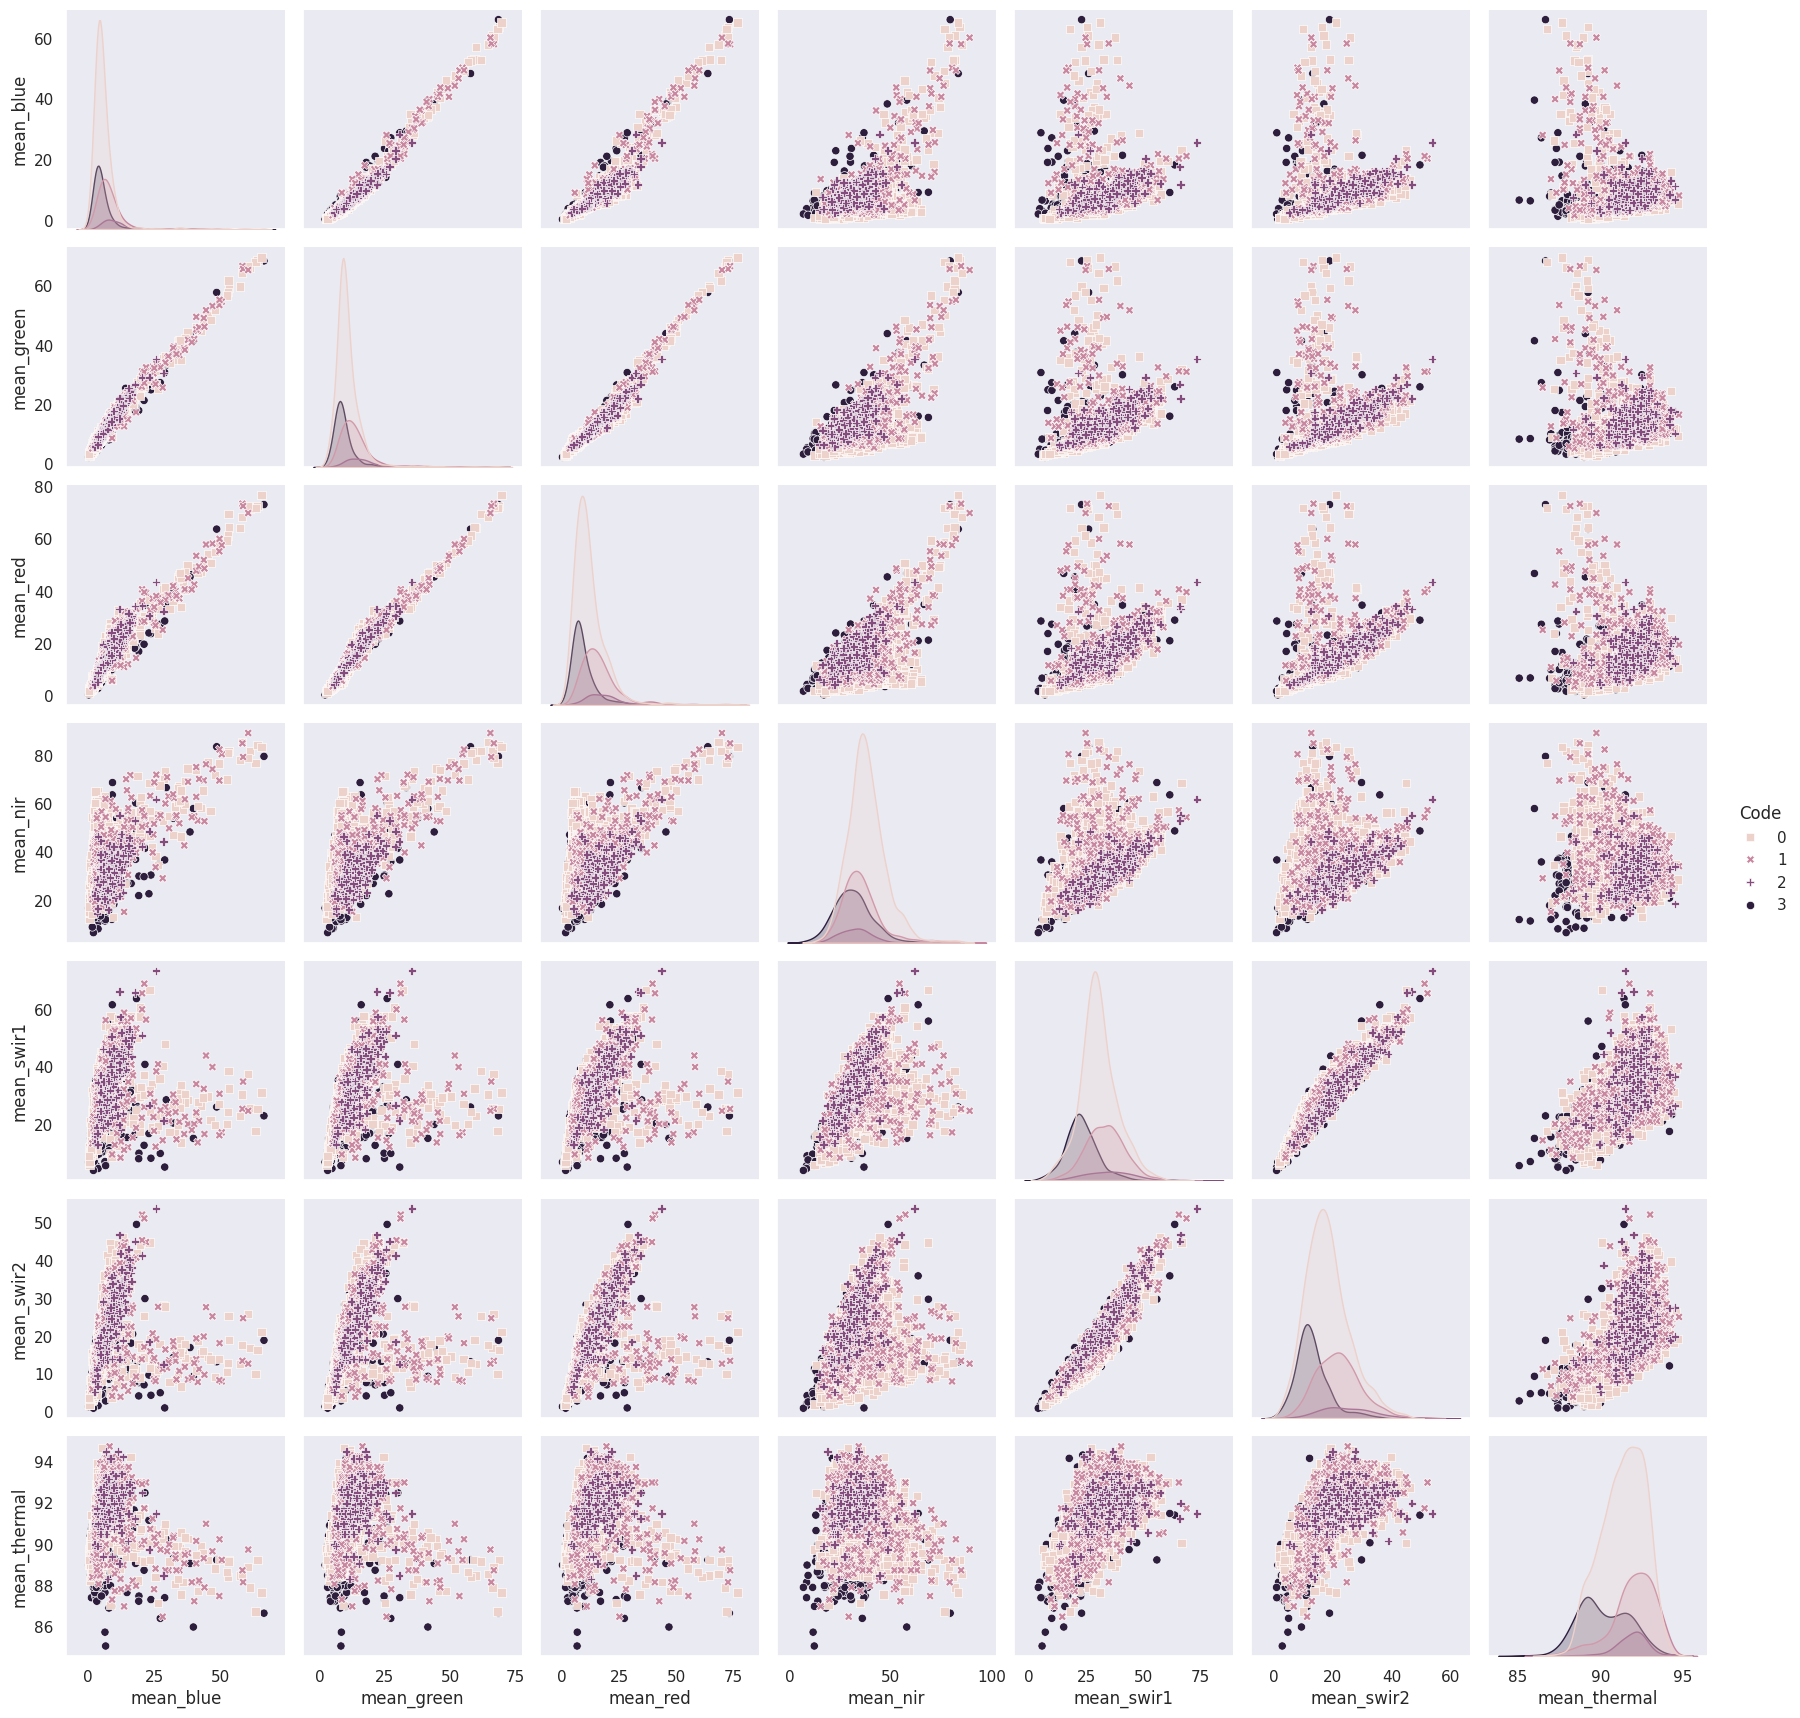

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Load example data (you can replace this with your own dataset)
features = ['mean_blue', 'mean_green', 'mean_red',
            'mean_nir', 'mean_swir1', 'mean_swir2', 'mean_thermal', 'Code']


df = train[features]

markers =  {0: "s", 1: "X", 2: "P", 3: "o" }

# Create scatterplot matrix
sns.set(style="dark")
sns.pairplot(df, hue="Code", markers=markers)

# Show the plot
plt.show()

## Generating Indices using Interesting Bands

In [39]:
interesting_bands = []

### Making Band combinations of the bands we find interesting
bands = ['mean_nir', 'mean_swir1', 'mean_swir2', 'mean_thermal']

# Get all possible two combinations
two_combinations = list(combinations(bands, 2))

# Print the result
for combo in two_combinations:
    interesting_bands.append(combo)
interesting_bands

[('mean_nir', 'mean_swir1'),
 ('mean_nir', 'mean_swir2'),
 ('mean_nir', 'mean_thermal'),
 ('mean_swir1', 'mean_swir2'),
 ('mean_swir1', 'mean_thermal'),
 ('mean_swir2', 'mean_thermal')]

In [40]:
for combo in interesting_bands:
    train[combo[0]+'_'+combo[1]+ '_ratio'] = train[combo[0]] - (train[slope_col[0]] * train[combo[1]])
    train[combo[1]+'_'+combo[0]+ '_ratio'] = train[combo[1]] - (train[slope_col[0]] * train[combo[0]])

    test[combo[0]+'_'+combo[1]+ '_ratio'] = test[combo[0]] - (test[slope_col[0]] * test[combo[1]])
    test[combo[1]+'_'+combo[0]+ '_ratio'] = test[combo[1]] - (test[slope_col[0]] * test[combo[0]])


## Remove columns not needed for training

In [41]:
training_columns = ['Year',
 'WDVI',
 'nightlights.average_min',
 'mean_nir_mean_swir2_ratio',
 'nightlights.average_max',
 'Coor_y',
 'clm_std',
 'mean_nir_mean_thermal_ratio',
 'mean_swir1_mean_thermal_ratio',
 'nightlights.average_viirs.v21_m_500m_s_{year}0101_{year}1231_go_epsg4326_v20230318',
 'nightlights.average_mean',
 'mean_thermal_mean_swir2_ratio',
 'fapar_max',
 'bs_mean',
 'mean_swir1_mean_swir2_ratio',
 'ndsi_min',
 'bioclim.var_chelsa.bio2_m_1km_s_1981_2010_go_epsg.4326_v20231002',
 'clm_max',
 'evi_max',
 'dtm_max',
 'bioclim.var_min',
 'clm_lst_mod11a2.daytime_p95_1km_s0..0cm_{year}_v1.2',
 'clm_min',
 'bs_max',
 'bs_min',
 'dtm_skew',
 'bs_glad.landsat.seasconv.m.yearly_sum_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
 'mean_swir2_mean_thermal_ratio',
 'ndvi_glad.landsat.seasconv.m.yearly_p75_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
 'pos.openess_min',
 'evi_glad.landsat.seasconv_m_30m_s_{year}0501_{year}0630_eu_epsg.3035_v20231127',
 'wv_mcd19a2v061.seasconv.m.yearly_p25_1km_s_{year}0101_{year}1231_go_epsg.4326_v20230619',
 'mean_thermal_mean_swir1_ratio',
 'Coor_x',
 'pos.openess_max',
 'dtm_elev.lowestmode_gedi.eml_mf_30m_0..0cm_2000..2018_eumap_epsg3035_v0.3',
 'pos.openess_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002',
 'mean_nir_mean_swir1_ratio',
 'ndsi_glad.landsat.seasconv_m_30m_s_{year}0701_{year}0831_eu_epsg.3035_v20231127',
 'pos.openess_mean',
 'dtm_kurt',
 'mean_swir2_mean_swir1_ratio',
 'wv_min',
 'dtm_mean',
 'bioclim.var_chelsa.bio3_m_1km_s_1981_2010_go_epsg.4326_v20231002',
 'tasseled_cap_brightness',
 'evi_std',
 'wv_mean',
 'clm_lst_mod11a2.nighttime_sd_1km_s0..0cm_{year}_v1.2',
 'landform_mean',
 'ndvi_max',
 'clm_lst_mod11a2.nighttime_p95_1km_s0..0cm_{year}_v1.2',
 'ndsi_glad.landsat.seasconv_m_30m_s_{year}0501_{year}0630_eu_epsg.3035_v20231127',
 'clm_lst_mod11a2.nighttime_p05_1km_s0..0cm_{year}_v1.2',
 'wv_max',
 'landform.dissected.terrace.moderate.plateau_mean',
 'wv_skew',
 'wv_mcd19a2v061.seasconv.m.yearly_sd_1km_s_{year}0101_{year}1231_go_epsg.4326_v20230619',
 'slope_nunique',
 'clm_skew',
 'vbf_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002',
 'dtm_std',
 'landform_terrain.class_c_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002',
 'ndsi_glad.landsat.seasconv_m_30m_s_{year}0901_{year}1031_eu_epsg.3035_v20231127',
 'slope_std',
 'fapar_glad.landsat.seasconv_m_30m_s_{year}0301_{year}0430_eu_epsg.3035_v20231127',
 'snow.prob_mean',
 'mean_swir1',
 'fapar_std',
 'twi',
 'clm_lst_mod11a2.daytime_p05_1km_s0..0cm_{year}_v1.2',
 'evi_glad.landsat.seasconv_m_30m_s_{year}0701_{year}0831_eu_epsg.3035_v20231127',
 'bioclim.var_kurt',
 'bioclim.var_max',
 'vbf_mean',
 'lcv_mean',
 'landform_skew',
 'ndvi_glad.landsat.seasconv.m.yearly_p50_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
 'fapar_glad.landsat.seasconv_m_30m_s_{year}0501_{year}0630_eu_epsg.3035_v20231127',
 'fapar_glad.landsat.seasconv_m_30m_s_{year}0901_{year}1031_eu_epsg.3035_v20231127',
 'mean_savi',
 'clm_lst_mod11a2.nighttime_p50_1km_s0..0cm_{year}_v1.2',
 'lcv_globalcropland_bowen.et.al_p_1km_s0..0cm_{year}_v0.1',
 'wetlands.regularly-flooded_upmc.wtd_p_250m_b0..200cm_2010_2015_go_epsg.4326_v20231002',
 'mean_thermal',
 'snow.prob_esacci.m12_p90_500m_s_2000_2012_go_epsg.4326_v20231002',
 'snow.prob_std',
 'evi_glad.landsat.seasconv_m_30m_s_{year}0301_{year}0430_eu_epsg.3035_v20231127',
 'wv_mcd19a2v061.seasconv.m.yearly_p75_1km_s_{year}0101_{year}1231_go_epsg.4326_v20230619',
 'landform.middle.large.slope_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002',
 'mean_swir2_mean_nir_ratio',
 'vbf_max',
 'ndvi_nunique',
 'mean_nir',
 'clm_accum.precipitation_chelsa.annual_m_1km_s0..0cm_{year}_v2.1',
 'clm_lst_mod11a2.daytime_p50_1km_s0..0cm_{year}_v1.2',
 'snow.prob_max',
 'snow.prob_esacci.m10_p90_500m_s_2000_2012_go_epsg.4326_v20231002',
 'slope_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002',
 'bioclim.var_skew',
 'fapar_glad.landsat.seasconv_m_30m_s_{year}0701_{year}0831_eu_epsg.3035_v20231127',
 'snow.prob_esacci.m01_p90_500m_s_2000_2012_go_epsg.4326_v20231002',
 'snow.prob_esacci.m10_sd_500m_s_2000_2012_go_epsg.4326_v20231002',
 'bioclim.var_chelsa.bio12_m_1km_s_1981_2010_go_epsg.4326_v20231002',
 'mean_blue',
 'snow.prob_min',
 'wv_std',
 'fapar_mean',
 'vbf_min',
 'snow.prob_esacci.m09_sd_500m_s_2000_2012_go_epsg.4326_v20231002',
 'slope_min',
 'lcv_std',
 'snow.prob_esacci.m12_sd_500m_s_2000_2012_go_epsg.4326_v20231002',
 'lcv_max',
 'dtm_lithology_usgs.ecotapestry.intermediate.plutonics_p_250m_s0..0cm_2014_v1.0',
 'clm_nunique',
 'clm_lst_mod11a2.daytime_sd_1km_s0..0cm_{year}_v1.2',
 'dtm_lithology_usgs.ecotapestry.siliciclastic.sedimentary_p_250m_s0..0cm_2014_v1.0',
 'ndsi_glad.landsat.seasconv_m_30m_s_{year}0101_{year}0228_eu_epsg.3035_v20231127',
 'upslope.curvature_min',
 'ndsi_glad.landsat.seasconv_m_30m_s_{year}0301_{year}0430_eu_epsg.3035_v20231127',
 'wetlands.regularly-flooded_min',
 'ndsi_mean',
 'wv_kurt',
 'downslope.curvature_mean',
 'clm_mean',
 'wetlands.cw_upmc.wtd_c_250m_b0..200cm_2010_2015_go_epsg.4326_v20231002',
 'downslope.curvature_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002',
 'ndvi_glad.landsat.seasconv.m.yearly_p25_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
 'log1p.upstream.area_merit.hydro_m_250m_b0..0cm_2017_2017_go_epsg.4326_v20231002',
 'snow.prob_esacci.m03_p90_500m_s_2000_2012_go_epsg.4326_v20231002',
 'log1p.upstream.area_min',
 'land_surface_temp',
 'clm_kurt',
 'snow.prob_esacci.m11_sd_500m_s_2000_2012_go_epsg.4326_v20231002',
 'ndsi_std',
 'ndvi_mean',
 'upslope.curvature_max',
 'snow.prob_esacci.m03_sd_500m_s_2000_2012_go_epsg.4326_v20231002',
 'mean_red',
 'wetlands.regularly-flooded_mean',
 'slope_mean',
 'ls_factor',
 'snow.prob_esacci.m05_sd_500m_s_2000_2012_go_epsg.4326_v20231002',
 'mean_swir1_mean_nir_ratio',
 'fapar_glad.landsat.seasconv_m_30m_s_{year}0101_{year}0228_eu_epsg.3035_v20231127',
 'wv_mcd19a2v061.seasconv.m.yearly_p50_1km_s_{year}0101_{year}1231_go_epsg.4326_v20230619',
 'downslope.curvature_max',
 'snow.prob_esacci.m01_sd_500m_s_2000_2012_go_epsg.4326_v20231002',
 'wetlands.regularly-flooded_max',
 'fapar_min',
 'log1p.upstream.area_mean',
 'dtm_lithology_usgs.ecotapestry.acid.volcanic_p_250m_s0..0cm_2014_v1.0',
 'snow.prob_esacci.m11_p90_500m_s_2000_2012_go_epsg.4326_v20231002',
 'snow.prob_esacci.m02_p90_500m_s_2000_2012_go_epsg.4326_v20231002']

In [42]:

columns = [col for col in train.columns if col not in not_needed_columns]

print(f"Length of columns: {len(columns)-1}")

Length of columns: 372


### Clean the names of the columns

In [43]:
training_dataset = train[training_columns]
testing_dataset = test[training_columns]

# Replace spaces with underscores
training_dataset.columns = training_dataset.columns.str.replace(' ', '_')
testing_dataset.columns = testing_dataset.columns.str.replace(' ', '_')

# Remove other special characters
training_dataset.columns = training_dataset.columns.str.replace('[^a-zA-Z0-9]', '', regex=True)
testing_dataset.columns = testing_dataset.columns.str.replace('[^a-zA-Z0-9]', '', regex=True)


# Modelling

### Features Used

In [44]:
training_features = ['Year',
 'WDVI',
 'nightlightsaveragemin',
 'meannirmeanswir2ratio',
 'nightlightsaveragemax',
 'Coory',
 'clmstd',
 'meannirmeanthermalratio',
 'meanswir1meanthermalratio',
 'nightlightsaverageviirsv21m500msyear0101year1231goepsg4326v20230318',
 'nightlightsaveragemean',
 'meanthermalmeanswir2ratio',
 'faparmax',
 'bsmean',
 'meanswir1meanswir2ratio',
 'ndsimin',
 'bioclimvarchelsabio2m1kms19812010goepsg4326v20231002',
 'clmmax',
 'evimax',
 'dtmmax',
 'bioclimvarmin',
 'clmlstmod11a2daytimep951kms00cmyearv12',
 'clmmin',
 'bsmax',
 'bsmin',
 'dtmskew',
 'bsgladlandsatseasconvmyearlysum30msyear0101year1231euepsg3035v20231127',
 'meanswir2meanthermalratio',
 'ndvigladlandsatseasconvmyearlyp7530msyear0101year1231euepsg3035v20231127',
 'posopenessmin',
 'evigladlandsatseasconvm30msyear0501year0630euepsg3035v20231127',
 'wvmcd19a2v061seasconvmyearlyp251kmsyear0101year1231goepsg4326v20230619',
 'meanthermalmeanswir1ratio',
 'Coorx',
 'posopenessmax',
 'dtmelevlowestmodegediemlmf30m00cm20002018eumapepsg3035v03',
 'posopenessmeritdemm250ms00cm20172017goepsg4326v20231002',
 'meannirmeanswir1ratio',
 'ndsigladlandsatseasconvm30msyear0701year0831euepsg3035v20231127',
 'posopenessmean',
 'dtmkurt',
 'meanswir2meanswir1ratio',
 'wvmin',
 'dtmmean',
 'bioclimvarchelsabio3m1kms19812010goepsg4326v20231002',
 'tasseledcapbrightness',
 'evistd',
 'wvmean',
 'clmlstmod11a2nighttimesd1kms00cmyearv12',
 'landformmean',
 'ndvimax',
 'clmlstmod11a2nighttimep951kms00cmyearv12',
 'ndsigladlandsatseasconvm30msyear0501year0630euepsg3035v20231127',
 'clmlstmod11a2nighttimep051kms00cmyearv12',
 'wvmax',
 'landformdissectedterracemoderateplateaumean',
 'wvskew',
 'wvmcd19a2v061seasconvmyearlysd1kmsyear0101year1231goepsg4326v20230619',
 'slopenunique',
 'clmskew',
 'vbfmeritdemm250ms00cm20172017goepsg4326v20231002',
 'dtmstd',
 'landformterrainclassc250ms00cm20172018goepsg4326v20231002',
 'ndsigladlandsatseasconvm30msyear0901year1031euepsg3035v20231127',
 'slopestd',
 'fapargladlandsatseasconvm30msyear0301year0430euepsg3035v20231127',
 'snowprobmean',
 'meanswir1',
 'faparstd',
 'twi',
 'clmlstmod11a2daytimep051kms00cmyearv12',
 'evigladlandsatseasconvm30msyear0701year0831euepsg3035v20231127',
 'bioclimvarkurt',
 'bioclimvarmax',
 'vbfmean',
 'lcvmean',
 'landformskew',
 'ndvigladlandsatseasconvmyearlyp5030msyear0101year1231euepsg3035v20231127',
 'fapargladlandsatseasconvm30msyear0501year0630euepsg3035v20231127',
 'fapargladlandsatseasconvm30msyear0901year1031euepsg3035v20231127',
 'meansavi',
 'clmlstmod11a2nighttimep501kms00cmyearv12',
 'lcvglobalcroplandbowenetalp1kms00cmyearv01',
 'wetlandsregularlyfloodedupmcwtdp250mb0200cm20102015goepsg4326v20231002',
 'meanthermal',
 'snowprobesaccim12p90500ms20002012goepsg4326v20231002',
 'snowprobstd',
 'evigladlandsatseasconvm30msyear0301year0430euepsg3035v20231127',
 'wvmcd19a2v061seasconvmyearlyp751kmsyear0101year1231goepsg4326v20230619',
 'landformmiddlelargeslopeterrainclassp250ms00cm20172018goepsg4326v20231002',
 'meanswir2meannirratio',
 'vbfmax',
 'ndvinunique',
 'meannir',
 'clmaccumprecipitationchelsaannualm1kms00cmyearv21',
 'clmlstmod11a2daytimep501kms00cmyearv12',
 'snowprobmax',
 'snowprobesaccim10p90500ms20002012goepsg4326v20231002',
 'slopemeritdemm250ms00cm20172017goepsg4326v20231002',
 'bioclimvarskew',
 'fapargladlandsatseasconvm30msyear0701year0831euepsg3035v20231127',
 'snowprobesaccim01p90500ms20002012goepsg4326v20231002',
 'snowprobesaccim10sd500ms20002012goepsg4326v20231002',
 'bioclimvarchelsabio12m1kms19812010goepsg4326v20231002',
 'meanblue',
 'snowprobmin',
 'wvstd',
 'faparmean',
 'vbfmin',
 'snowprobesaccim09sd500ms20002012goepsg4326v20231002',
 'slopemin',
 'lcvstd',
 'snowprobesaccim12sd500ms20002012goepsg4326v20231002',
 'lcvmax',
 'dtmlithologyusgsecotapestryintermediateplutonicsp250ms00cm2014v10',
 'clmnunique',
 'clmlstmod11a2daytimesd1kms00cmyearv12',
 'dtmlithologyusgsecotapestrysiliciclasticsedimentaryp250ms00cm2014v10',
 'ndsigladlandsatseasconvm30msyear0101year0228euepsg3035v20231127',
 'upslopecurvaturemin',
 'ndsigladlandsatseasconvm30msyear0301year0430euepsg3035v20231127',
 'wetlandsregularlyfloodedmin',
 'ndsimean',
 'wvkurt',
 'downslopecurvaturemean',
 'clmmean',
 'wetlandscwupmcwtdc250mb0200cm20102015goepsg4326v20231002',
 'downslopecurvaturemeritdemm250ms00cm20172017goepsg4326v20231002',
 'ndvigladlandsatseasconvmyearlyp2530msyear0101year1231euepsg3035v20231127',
 'log1pupstreamareamerithydrom250mb00cm20172017goepsg4326v20231002',
 'snowprobesaccim03p90500ms20002012goepsg4326v20231002',
 'log1pupstreamareamin',
 'landsurfacetemp',
 'clmkurt',
 'snowprobesaccim11sd500ms20002012goepsg4326v20231002',
 'ndsistd',
 'ndvimean',
 'upslopecurvaturemax',
 'snowprobesaccim03sd500ms20002012goepsg4326v20231002',
 'meanred',
 'wetlandsregularlyfloodedmean',
 'slopemean',
 'lsfactor',
 'snowprobesaccim05sd500ms20002012goepsg4326v20231002',
 'meanswir1meannirratio',
 'fapargladlandsatseasconvm30msyear0101year0228euepsg3035v20231127',
 'wvmcd19a2v061seasconvmyearlyp501kmsyear0101year1231goepsg4326v20230619',
 'downslopecurvaturemax',
 'snowprobesaccim01sd500ms20002012goepsg4326v20231002',
 'wetlandsregularlyfloodedmax',
 'faparmin',
 'log1pupstreamareamean',
 'dtmlithologyusgsecotapestryacidvolcanicp250ms00cm2014v10',
 'snowprobesaccim11p90500ms20002012goepsg4326v20231002',
 'snowprobesaccim02p90500ms20002012goepsg4326v20231002']

In [45]:
len(training_features)

155

### Voting Classifier Cross Validation

In [52]:
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X, y  = training_dataset[training_features], train['Code']

feats = pd.DataFrame({'features': X.columns})
gbm_predictions = []
cv_score_ = 0
oof_preds = np.zeros((train.shape[0],))


all_preds = []
all_true_labels = []

for i,(tr_index,test_index) in enumerate(stratified_kf.split(X,y)):
    print()
    print(f'######### FOLD {i+1} / {stratified_kf.n_splits} ')

    X_train,y_train = X.iloc[tr_index,:],y[tr_index]
    X_test,y_test = X.iloc[test_index,:],y[test_index]


    # for xgb model
    xgb_gbm = xgb.XGBClassifier(
                            gamma = 0.23,
                            n_estimators=2000,
                            max_depth=12,
                            learning_rate=0.01,
                            subsample=0.8,
                            colsample_bytree=0.4,
                            missing=-1,
                            device='cuda',
                            # early_stopping_rounds= 200,
                            )


    # for lightgbm model
    warnings.filterwarnings("ignore", category=UserWarning, message="[LightGBM] \[Warning\] No further splits with positive gain, best gain: -inf")
    params  = {
   'boosting_type': 'dart','n_estimators':2500,'objective': 'multiclass',
    'learning_rate':0.02, 'num_leaves':15,'reg_alpha':0,'reg_lambda':7,
    'max_depth':5,
    'random_state':42,'verbose': -1}
    lgb_gbm = lgb.LGBMClassifier(**params)



    #catboost classifier
    cat_gbm = CatBoostClassifier(
        loss_function='MultiClass',
        depth = 6,
        task_type="GPU",
        learning_rate=0.01,
        iterations=4000,
        od_type="Iter",
        random_seed=24,
        silent=True,
    )


    # voting
    voting_classifier = VotingClassifier(
    estimators=[
        ('xgboost', xgb_gbm),
        ('lightgbm', lgb_gbm),
        ('catboost', cat_gbm),
    ],
    voting='soft',
    )
    voting_classifier.fit(X_train, y_train)

    cv_score_ += f1_score(y_test, voting_classifier.predict(X_test), average='weighted') / stratified_kf.n_splits
    fold_preds = voting_classifier.predict(X_test)
    all_preds.extend(fold_preds)
    all_true_labels.extend(y_test)


    # for testing
    oof_preds[test_index] = voting_classifier.predict(X_test)

    preds = voting_classifier.predict(testing_dataset[training_features])
    gbm_predictions.append(preds)


print(' CV F1_Score : ', cv_score_)



######### FOLD 1 / 5 

######### FOLD 2 / 5 

######### FOLD 3 / 5 

######### FOLD 4 / 5 

######### FOLD 5 / 5 
 CV F1_Score :  0.8591788519081984


Text(0.5, 1.0, 'Confusion Matrix')

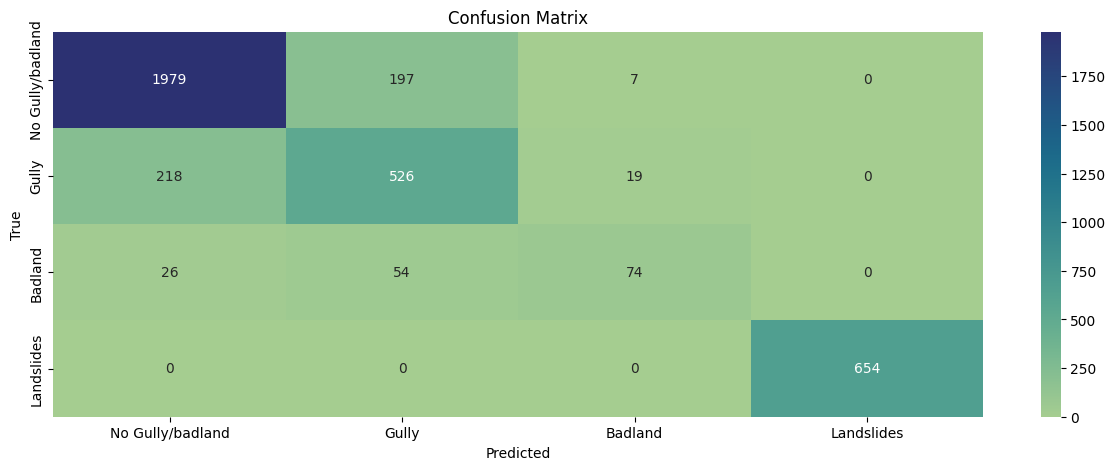

In [47]:
overall_cm = confusion_matrix(all_true_labels, all_preds)
labels = ['No Gully/badland', 'Gully', 'Badland', 'Landslides']
plt.figure(figsize=(15, 5))
sns.heatmap(overall_cm, annot=True, fmt="d", cmap="crest", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


In [48]:
string_class_preds = ['No Gully/badland' if label == 0 else
                'Gully' if label == 1 else 'Badland' if label == 2 else
                'Landslides' for label in all_preds]

string_class_true = ['No Gully/badland' if label == 0 else
                'Gully' if label == 1 else 'Badland' if label == 2 else
                'Landslides' for label in all_true_labels]

In [49]:
report = classification_report(string_class_true, string_class_preds)
print(report)

                  precision    recall  f1-score   support

         Badland       0.74      0.48      0.58       154
           Gully       0.68      0.69      0.68       763
      Landslides       1.00      1.00      1.00       654
No Gully/badland       0.89      0.91      0.90      2183

        accuracy                           0.86      3754
       macro avg       0.83      0.77      0.79      3754
    weighted avg       0.86      0.86      0.86      3754



### Submission

In [ ]:
from scipy.stats import mode

predictions_array = np.array(gbm_predictions)

# Find the mode along each column using scipy.stats.mode
result = mode(predictions_array, axis=0)

# Extract the mode values
mode_values = result.mode.squeeze()

test['Code'] = mode_values

pred_df = test[['sample_id', 'Code']]

pred_df.to_csv('retrying_sub_voting_classifier_top_155.csv', index=False)